In [1]:
import os
import codecs
import re

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [7]:
np.random.seed(0)

In [8]:
languages = set(['EN', 'JP'])
data_train = {language: None for language in languages}
data_validation = {language: None for language in languages}
emb_matrix = {language: None for language in languages}

In [9]:
dim_seq = {language: None for language in languages}
dim_vocab = {language: None for language in languages}
dim_emb =  {language: 300 for language in languages}
tokenizer = {language: None for language in languages}

In [10]:
detokenizer = {language: None for language in languages}

In [11]:
# Data Preparation

In [12]:
def tokenize(lines):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in lines:
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [13]:
# path_input = './Data/22/output/corpus.csv'
path_input = '/root/userspace/private/FinalExam/Data/040/input/'

In [14]:
files = os.listdir(path_input)

df = pd.DataFrame()

for i, file in enumerate(files):
    print('{0:02d}/{1:02d}: {2}'.format(i+1, len(files), file))
    
    if re.match('\..*', file):
        print('Incorrect file: {0}\n'.format(file))
        continue
    elif os.path.isdir(path_input + file):
        print('Directory {0}\n'.format(file))
        continue
    
    print('Loading corpus data')
    df_claims = pd.read_csv(path_input + file)
    
    print('\n')
    print(df_claims.info())
    print('\n')
    
    print('Concatenating data frame')
    df = pd.concat([df, df_claims])
    print('Concatenating data frame is finished\n')

01/03: corpus_01.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15767 entries, 0 to 15766
Data columns (total 5 columns):
id_doc       15767 non-null object
id_claim     15767 non-null int64
claim_JP     15767 non-null object
claim_EP     15767 non-null object
length_EP    15767 non-null int64
dtypes: int64(2), object(3)
memory usage: 616.0+ KB
None


Concatenating data frame
Concatenating data frame is finished

02/03: wvec
Directory wvec

03/03: corpus_02.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10514 entries, 0 to 10513
Data columns (total 5 columns):
id_doc       10514 non-null object
id_claim     10514 non-null int64
claim_JP     10514 non-null object
claim_EP     10514 non-null object
length_EP    10514 non-null int64
dtypes: int64(2), object(3)
memory usage: 410.8+ KB
None


Concatenating data frame
Concatenating data frame is finished



In [15]:
df = df[df['length_EP'] < df['length_EP'].describe()['50%']]

In [16]:
df_columns = {'EN': 'claim_EP', 'JP': 'claim_JP'}

In [17]:
for language in languages:
    data_train[language], tokenizer[language] = tokenize(df[df_columns[language]].tolist())
    dim_vocab[language] = len(tokenizer[language].word_index) + 1
    print('{0} vocab size: {1}'.format(language, dim_vocab[language]))

EN vocab size: 6932
JP vocab size: 5781


In [18]:
data_train['EN'], data_validation['EN'], data_train['JP'], data_validation['JP'] = train_test_split(
                                                                                       data_train['EN'],
                                                                                       data_train['JP'],
                                                                                       test_size=0.01,
                                                                                       random_state=42
                                                                                   )

In [19]:
for language in languages:
    data_train[language] = pad_sequences(data_train[language], padding='post')
    dim_seq[language] = len(data_train[language][0])
    print('Dim {0} sequence: {1}'.format(language, dim_seq[language]))

Dim EN sequence: 45
Dim JP sequence: 106


In [20]:
# Creating embedding matrix

In [21]:
# path_input_wvec = {'EN': 'Data/20/output/wvec/EN/',
#                   'JP': 'Data/20/output/wvec/JP/'}
path_input_wvec = {'EN': '/root/userspace/private/FinalExam/Data/040/input/wvec/EN/',
                   'JP': '/root/userspace/private/FinalExam/Data/040/input/wvec/JP/'}

In [22]:
for language in languages:
    print('Extracting {0} emb vectors'.format(language))
    
    emb_matrix[language] = np.zeros(shape=(dim_vocab[language], dim_emb[language]), dtype=np.float32)
    
    files = os.listdir(path_input_wvec[language])
    for file in files:
        fin = codecs.open(path_input_wvec[language]+file, 'r', 'utf-8')
        for line in fin:
            tokens = line.rstrip().split(' ')
            if tokens[0] in tokenizer[language].word_index.keys():
                emb_matrix[language][tokenizer[language].word_index[tokens[0]]] = tokens[1:]

Extracting EN emb vectors
Extracting JP emb vectors


In [23]:
vector_bos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_bos[0] = 1.0 
vector_eos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_eos[dim_emb[language]-1] = 1.0 

for language in languages:
    emb_matrix[language][tokenizer[language].word_index['<s>']] = vector_bos
    emb_matrix[language][tokenizer[language].word_index['</s>']] = vector_eos

In [24]:
# Building a model

In [25]:
class RNNEncoderDecoderAtt(object):
    def __init__(self,
                 dim_input_seq,
                 dim_input_vocab,
                 dim_output_seq,
                 dim_output_vocab,
                 dim_emb,
                 dim_hid, 
                 dim_att,
                 emb_matrix_input,
                 emb_matrix_output):
        
        self.dim_input_seq = dim_input_seq
        self.dim_input_vocab = dim_input_vocab
        
        self.dim_output_seq = dim_output_seq
        self.dim_output_vocab = dim_output_vocab
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        self.dim_att = dim_att
        
        self.emb_matrix_input = emb_matrix_input
        self.emb_matrix_output = emb_matrix_output
        
        # Model
        self._model = None
        self._model_validation_encoder = None
        self._model_validation_decoder = None
        self._model_validation_attention = None
        
        # Encoder 
        ## Layer
        self._encoder_inputs = None
        
        ## Tensor
        self._encoded_seq = None
        self._encoder_states = None
        
        # Decoder
        ## Layer
        self._decoder_embedding = None
        self._decoder_lstm = None
        self._decoder_dense = None

        # Attension
        ## Layer
        self._attention_score_dense = None
        self._attention_dense = None
        
        # Output
        ## Layer
        self._output_dense = None
        
    def inference(self):
        from keras.models import Model
        from keras.layers import Input, Embedding, Dense, LSTM, concatenate, dot, Activation

        # Encoder
        ## Input Layer
        self._encoder_inputs = Input(shape=(self.dim_input_seq,))

        ## Embedding Layer
        encoder_embedded = Embedding(self.dim_input_vocab,
                                     self.dim_emb,
                                     weights=[self.emb_matrix_input],
                                     mask_zero=True,
                                     trainable=False)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        ## LSTM Layer
        self._encoded_seq, *(self._encoder_states) = LSTM(self.dim_hid, return_sequences=True, return_state=True)(encoder_embedded)  # (dim_seq_input, dim_emb)->(dim_seq_input, dim_hid)

        # Decoder
        ## Instance
        self._decoder_embedding = Embedding(self.dim_output_vocab,
                                            self.dim_emb,
                                            weights=[self.emb_matrix_output],
                                            trainable=False)
        
        self._decoder_lstm = LSTM(self.dim_hid, return_sequences=True, return_state=True)
        
        ## Input Layer
        decoder_inputs = Input(shape=(self.dim_output_seq,))

        ## Embedding Layer
        decoder_embedded = self._decoder_embedding(decoder_inputs)  # (dim_seq_output,)->(dim_seq_output, dim_emb)
        
        ## LSTM Layer       
        decoded_seq, _, _ = self._decoder_lstm(decoder_embedded, initial_state=self._encoder_states) # (dim_seq_output, dim_emb)->(dim_seq_output, dim_hid)
        
        # Attention
        ## Instance
        self._attention_score_dense = Dense(self.dim_hid)
        self._attention_dense = Dense(self.dim_att, activation='tanh')
        
        ## Attention
        score = self._attention_score_dense(decoded_seq)        # (dim_seq_output, dim_hid) -> (dim_seq_output, dim_hid)
        score = dot([score, self._encoded_seq], axes=(2,2))           # [(dim_seq_output, dim_hid), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_seq_input)
        attention = Activation('softmax')(score)                # (dim_seq_output, dim_seq_input) -> (dim_seq_output, dim_seq_input)

        ## Context
        context = dot([attention, self._encoded_seq], axes=(2,1))     # [(dim_seq_output, dim_seq_input), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_hid)
        concat = concatenate([context, decoded_seq], axis=2)    # [(dim_seq_output, dim_hid), (dim_seq_output, dim_hid)] -> (dim_seq_output, 2*dim_hid)
        attentional = self._attention_dense(concat)             # (dim_seq_output, 2*hid_dim) -> (dim_seq_output, dim_att)
        
        # Output Layer
        ## Instance
        self._output_dense = Dense(self.dim_output_vocab, activation='softmax')
        
        ## Output
        predictions = self._output_dense(attentional)  # (dim_seq_output, dim_att) -> (dim_seq_output, dim_vocab_output)
        
        return Model([self._encoder_inputs, decoder_inputs], predictions)

    def compile(self):
        self._model = self.inference()
        self._model.compile(loss='sparse_categorical_crossentropy',
                            optimizer='rmsprop',
                            metrics=['accuracy'])
        
    def fit(self, X_train, Y_train, epochs, batch_size, verbose=1):
        train_target = np.hstack((Y_train[:, 1:], np.zeros((len(Y_train),1), dtype=np.int32)))
        
        history = self._model.fit([X_train, Y_train],
                                  np.expand_dims(train_target, -1),
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=verbose,
                                  validation_split=0.2)
        
        return history.history
    
    def show_graph(self):
        return model_to_dot(self._model).create(prog='dot', format='svg')

In [26]:
model = RNNEncoderDecoderAtt(dim_input_seq=dim_seq['EN'],
                             dim_input_vocab=dim_vocab['EN'],
                             dim_output_seq=dim_seq['JP'],
                             dim_output_vocab=dim_vocab['JP'],
                             dim_emb=dim_emb['EN'],
                             dim_hid=256,
                             dim_att=256,
                             emb_matrix_input=emb_matrix['EN'],
                             emb_matrix_output=emb_matrix['JP'])

In [27]:
model.compile()

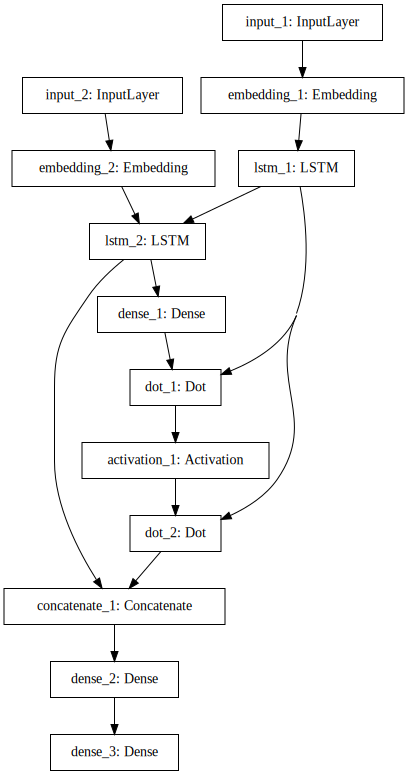

In [28]:
SVG(model.show_graph())

In [24]:
# Training the model

In [31]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=32*4)

Train on 10313 samples, validate on 2579 samples
Epoch 1/10
10313/10313 [==============================] - 98s 9ms/step - loss: 1.9362 - acc: 0.7175 - val_loss: 1.4273 - val_acc: 0.7528
Epoch 2/10
10313/10313 [==============================] - 98s 9ms/step - loss: 1.2246 - acc: 0.7859 - val_loss: 1.0574 - val_acc: 0.8161
Epoch 3/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.9669 - acc: 0.8340 - val_loss: 0.8990 - val_acc: 0.8442
Epoch 4/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.8488 - acc: 0.8499 - val_loss: 0.8251 - val_acc: 0.8545
Epoch 5/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.7801 - acc: 0.8578 - val_loss: 0.7628 - val_acc: 0.8619
Epoch 6/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.7259 - acc: 0.8641 - val_loss: 0.7221 - val_acc: 0.8665
Epoch 7/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.6816 - acc: 0.8695 - val_loss: 0.6837 - val_acc:

In [ ]:
# Confirming the result

In [ ]:
def show_graph(history, key, title=None, xlabel=None, ylabel=None, yscale=None):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.plot(history[key])

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if yscale:
        plt.yscale(yscale)

    plt.show()

In [ ]:
show_graph(history, 'val_loss', 'Validation Loss', 'Iteration', 'Validation Loss', 'log')

In [ ]:
show_graph(history, 'val_acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy', 'log')

In [32]:
for language in languages:
    detokenizer[language] = dict(map(reversed, tokenizer[language].word_index.items()))

In [34]:
detokenizer['JP'][0] = '0'

In [33]:
bos_eos = tokenizer['JP'].texts_to_sequences(["<s>", "</s>"])

In [35]:
def inference_validation(self):
    from keras.models import Model
    from keras.layers import Input, dot, concatenate, Activation

    # Encoder
    model_encoder = Model(self._encoder_inputs, [self._encoded_seq]+self._encoder_states)

    # Decoder
    decoder_inputs = Input(shape=(1,))
    decoder_inputs_states = [Input(shape=(self.dim_hid,)), Input(shape=(self.dim_hid,))]

    decoder_embeded = self._decoder_embedding(decoder_inputs)
    decoded_seq, *decoder_states = self._decoder_lstm(decoder_embeded, initial_state=decoder_inputs_states)

    model_decoder = Model([decoder_inputs] + decoder_inputs_states, [decoded_seq] + decoder_states)

    # Attention
    encoded_seq_in = Input(shape=(self.dim_input_seq, self.dim_hid))
    decoded_seq_in = Input(shape=(1, self.dim_hid))

    ## Score
    score = self._attention_score_dense(decoded_seq_in)
    score = dot([score, encoded_seq_in], axes=(2,2))
    attention = Activation('softmax')(score)

    ## Context
    context = dot([attention, encoded_seq_in], axes=(2,1))
    concat = concatenate([context, decoded_seq_in], axis=2)
    attentional = self._attention_dense(concat)

    # Output Layer
    predictions = self._output_dense(attentional)

    model_attention = Model([encoded_seq_in, decoded_seq_in], predictions)

    return model_encoder, model_decoder, model_attention

In [36]:
model._model_validation_encoder, model._model_validation_decoder, model._model_validation_attention = inference_validation(model)

In [37]:
def predict(self, X, bos_eos, max_output_length = 1000):
    encoded_seq, *states_value = self._model_validation_encoder.predict(X)

    target_seq = np.array(bos_eos[0])
    output_seq = bos_eos[0][:]

    while True:
        decoded_seq, *states_value = self._model_validation_decoder.predict([target_seq] + states_value)
        output_tokens = self._model_validation_attention.predict([encoded_seq, decoded_seq])
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index

        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

In [38]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(refs, preds):
    return np.mean([sentence_bleu(r, p, emulate_multibleu=True) for r, p in zip(refs, preds)])

In [39]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '熱', '交換', '剤', 'が', '、', '水', 'で', 'ある', '、', '請求', '項', '１', 'に', '記載', 'の', 'タイヤ', '。']
bleu: 0.7896895367562644

text_no: 1
元の文: ['a', 'device', 'obtained', 'by', 'the', 'method', 'for', 'forming', 'a', 'pattern', 'structure', 'according', 'to', 'any', 'one', 'of', 'claims', '14', 'to', '17', '.']
正解文: ['請求', '項', '１', '４', '乃至', '請求', '項', '１', '７', 'の', 'うち', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
生成文: ['請求', '項', '１', '１', 'から', '１', '１', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '方法', 'により', '得', 'られ', 'た', 'こと', 'を', '特徴', 'と', 'する', '車両', 'の', '製造', '方法', '。']
bleu: 0.7186082239261684

te

In [40]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '熱', '交換', '剤', 'が', '、', '水', 'で', 'ある', '、', '請求', '項', '１', 'に', '記載', 'の', 'タイヤ', '。']
bleu: 0.7896895367562644

text_no: 3
元の文: ['the', 'combination', 'medicine', 'according', 'to', 'claims', '13', 'or', '14', ',', 'characterized', 'in', 'that', 'an', 'aspect', 'of', 'said', 'combination', 'is', 'a', 'combination', 'drug', '.']
正解文: ['請求', '項', '１', '３', 'または', '１', '４', 'に', '記載', 'の', '組み合わせ', '医薬', 'で', 'あっ', 'て', '、', '前記', '組み合わせ', 'の', '態様', 'が', '、', '配合', '剤', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '、', '組合せ', '医薬', '。']
生成文: ['前記', '免疫', '剤', 'が', '、', 'ヒト', 'の', '使用', 'さ', 'れる', '、', '請求', '項', '１', '３', '又は', '１', '３', 'に', '記載', 'の', '医薬', '。']
bl

In [41]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=128)

Train on 10313 samples, validate on 2579 samples
Epoch 1/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.5448 - acc: 0.8873 - val_loss: 0.5824 - val_acc: 0.8859
Epoch 2/10
10313/10313 [==============================] - 98s 9ms/step - loss: 0.5162 - acc: 0.8917 - val_loss: 0.5564 - val_acc: 0.8896
Epoch 3/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.4886 - acc: 0.8962 - val_loss: 0.5395 - val_acc: 0.8927
Epoch 4/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.4629 - acc: 0.9006 - val_loss: 0.5268 - val_acc: 0.8938
Epoch 5/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.4378 - acc: 0.9053 - val_loss: 0.5060 - val_acc: 0.8983
Epoch 6/10
10313/10313 [==============================] - 98s 9ms/step - loss: 0.4142 - acc: 0.9099 - val_loss: 0.4914 - val_acc: 0.9021
Epoch 7/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.3912 - acc: 0.9142 - val_loss: 0.4804 - val_acc:

In [42]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'が', '水', '状', '体', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', 'ペット', 'ニードル', '。']
bleu: 0.8282477531331041

text_no: 1
元の文: ['a', 'device', 'obtained', 'by', 'the', 'method', 'for', 'forming', 'a', 'pattern', 'structure', 'according', 'to', 'any', 'one', 'of', 'claims', '14', 'to', '17', '.']
正解文: ['請求', '項', '１', '４', '乃至', '請求', '項', '１', '７', 'の', 'うち', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
生成文: ['請求', '項', '１', '８', '～', '１', '６', 'の', 'いずれ', 'か', '一', '項', 'に', '記載', 'の', 'パターン', 'の', '製造', '方法', 'を', '用い', 'た', 'こと', 'を', '特徴', 'と', 'する', 'デバイス', 'の', '製造', '方法', '。']
bleu: 0.683891199

In [43]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'が', '水', '状', '体', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', 'ペット', 'ニードル', '。']
bleu: 0.8282477531331041

text_no: 4
元の文: ['a', 'color', 'filter', 'comprising', 'the', 'cured', 'film', 'according', 'to', 'claim', '14', '.']
正解文: ['請求', '項', '１', '４', 'に', '記載', 'の', '硬化', '膜', 'を', '有する', 'カラー', 'フィルタ', '。']
生成文: ['請求', '項', '１', '６', 'に', '記載', 'の', '硬化', '膜', 'を', '有する', 'こと', 'を', '特徴', 'と', 'する', 'カラー', 'フィルタ', '。']
bleu: 0.7790872728179328

text_no: 6
元の文: ['the', 'liquid', 'detergent', 'according', 'to', 'claim', '1', 'or', '2', ',', 'wherein', 'the', 'mass', 'ratio', 'represented', 'by', '(', 'b', ')', '/', '(', 'c', ')', 'is', '1', 'or', 'greater'

In [44]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=128)

Train on 10313 samples, validate on 2579 samples
Epoch 1/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.3117 - acc: 0.9299 - val_loss: 0.4402 - val_acc: 0.9117
Epoch 2/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2944 - acc: 0.9335 - val_loss: 0.4275 - val_acc: 0.9149
Epoch 3/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2779 - acc: 0.9368 - val_loss: 0.4255 - val_acc: 0.9139
Epoch 4/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2626 - acc: 0.9399 - val_loss: 0.4243 - val_acc: 0.9153
Epoch 5/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2476 - acc: 0.9431 - val_loss: 0.4147 - val_acc: 0.9173
Epoch 6/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2340 - acc: 0.9460 - val_loss: 0.4092 - val_acc: 0.9181
Epoch 7/10
10313/10313 [==============================] - 97s 9ms/step - loss: 0.2208 - acc: 0.9490 - val_loss: 0.4075 - val_acc:

In [45]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'は', '、', '流体', '由来', 'の', '流体', 'で', 'ある', '、', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
bleu: 0.8507331335123524

text_no: 1
元の文: ['a', 'device', 'obtained', 'by', 'the', 'method', 'for', 'forming', 'a', 'pattern', 'structure', 'according', 'to', 'any', 'one', 'of', 'claims', '14', 'to', '17', '.']
正解文: ['請求', '項', '１', '４', '乃至', '請求', '項', '１', '７', 'の', 'うち', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
生成文: ['請求', '項', '１', '８', '～', '１', '９', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '構造', '構造', 'の', '形成', '方法', 'によって', '製造', 'さ', 'れ', 'た', 'デバイス', '。']
bleu: 0.7377879464668811

t

In [47]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'は', '、', '流体', '由来', 'の', '流体', 'で', 'ある', '、', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
bleu: 0.8507331335123524

text_no: 3
元の文: ['the', 'combination', 'medicine', 'according', 'to', 'claims', '13', 'or', '14', ',', 'characterized', 'in', 'that', 'an', 'aspect', 'of', 'said', 'combination', 'is', 'a', 'combination', 'drug', '.']
正解文: ['請求', '項', '１', '３', 'または', '１', '４', 'に', '記載', 'の', '組み合わせ', '医薬', 'で', 'あっ', 'て', '、', '前記', '組み合わせ', 'の', '態様', 'が', '、', '配合', '剤', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '、', '組合せ', '医薬', '。']
生成文: ['下記', 'の', '手段', 'が', '、', '組合せ', '性', 'な', '医薬', 'で', 'ある', '、', '請求', '項', '１', '３', 'または', '１', '３', 'に', '

In [48]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=5,
                    batch_size=128)

Train on 10313 samples, validate on 2579 samples
Epoch 1/5
10313/10313 [==============================] - 97s 9ms/step - loss: 0.1752 - acc: 0.9594 - val_loss: 0.4019 - val_acc: 0.9208
Epoch 2/5
10313/10313 [==============================] - 98s 9ms/step - loss: 0.1653 - acc: 0.9617 - val_loss: 0.3975 - val_acc: 0.9226
Epoch 3/5
10313/10313 [==============================] - 98s 9ms/step - loss: 0.1556 - acc: 0.9640 - val_loss: 0.3991 - val_acc: 0.9227
Epoch 4/5
10313/10313 [==============================] - 98s 9ms/step - loss: 0.1468 - acc: 0.9660 - val_loss: 0.4014 - val_acc: 0.9228
Epoch 5/5
10313/10313 [==============================] - 97s 9ms/step - loss: 0.1379 - acc: 0.9683 - val_loss: 0.3989 - val_acc: 0.9240


In [49]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'が', '、', '流体', '中', 'において', '液体', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '、', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
bleu: 0.8242367502646054

text_no: 1
元の文: ['a', 'device', 'obtained', 'by', 'the', 'method', 'for', 'forming', 'a', 'pattern', 'structure', 'according', 'to', 'any', 'one', 'of', 'claims', '14', 'to', '17', '.']
正解文: ['請求', '項', '１', '４', '乃至', '請求', '項', '１', '７', 'の', 'うち', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
生成文: ['請求', '項', '１', '４', '～', '１', '７', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
b

In [50]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in predict(model, input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'pouring', 'fitting', 'according', 'to', 'claim', '2', ',', 'wherein', 'said', 'liquid', 'is', 'immiscible', 'with', 'said', 'fluid', 'substance', '.']
正解文: ['前記', '液体', 'が', '、', '前記', '流動', '性', '物質', 'と', 'は', '非', '混和', '性', 'で', 'ある', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
生成文: ['前記', '液体', 'が', '、', '流体', '中', 'において', '液体', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '、', '請求', '項', '２', 'に', '記載', 'の', '注', '出', '具', '。']
bleu: 0.8242367502646054

text_no: 1
元の文: ['a', 'device', 'obtained', 'by', 'the', 'method', 'for', 'forming', 'a', 'pattern', 'structure', 'according', 'to', 'any', 'one', 'of', 'claims', '14', 'to', '17', '.']
正解文: ['請求', '項', '１', '４', '乃至', '請求', '項', '１', '７', 'の', 'うち', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
生成文: ['請求', '項', '１', '４', '～', '１', '７', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'パターン', '構造', 'の', '形成', '方法', 'により', '得', 'られ', 'た', 'デバイス', '。']
b